In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torchvision
from torchvision import transforms


REBUILD_DATA = True
IMG_SIZE = 100

class SnakesCucumbers():
    IMG_SIZE = 100
    SNAKES = "GreenImages/snake"
    CUCUMBERS = "GreenImages/cucumber"
    LABELS = {SNAKES: 0, CUCUMBERS: 1} 
    training_data = []
    snakecount = 0
    cucumbercount = 0

    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                #f je samo ime fajla
                try:
                    transform = transforms.Compose([transforms.ToPILImage(),transforms.RandomHorizontalFlip(p=0.5),transforms.RandomVerticalFlip(p=0.5)])
                    path = os.path.join(label,f)
                    #img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.imread(path)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    img2 = transform(img)
                    self.training_data.append([np.array(img), 
                                               np.eye(2)[self.LABELS[label]]])
                    self.training_data.append([np.array(img2), 
                                               np.eye(2)[self.LABELS[label]]])
                    if label == self.SNAKES:
                        self.snakecount += 1
                    elif label == self.CUCUMBERS:
                        self.cucumbercount += 1
                except Exception as e:
                    print(str(e))
                    pass
                
        np.random.shuffle(self.training_data)
        np.save("green_data.npy", self.training_data)
        print("Snakes", self.snakecount)
        print("Cucumbers", self.cucumbercount)

if REBUILD_DATA:
    SnakesVSCucumbers = SnakesCucumbers()
    SnakesVSCucumbers.make_training_data()

GreenImages/snake


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 202.40it/s]


GreenImages/cucumber


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.38it/s]
C:\Users\User\miniconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Snakes 100
Cucumbers 100


In [2]:
training_data = np.load("green_data.npy", allow_pickle = True)
print(len(training_data))

400


[0. 1.]


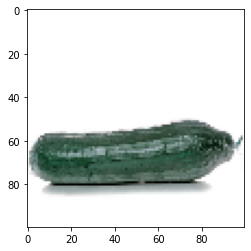

In [3]:

import torch

index = 1
print(training_data[index][1])
import matplotlib.pyplot as plt
#plt.imshow(training_data[index][0], cmap = "gray")
plt.imshow(training_data[index][0])
plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        
        x = torch.randn(IMG_SIZE,IMG_SIZE, 3).view(-1,3,IMG_SIZE,IMG_SIZE)
        self._to_linear_ = None
        self.convs(x)
        
        self.fc1 = nn.Linear( self._to_linear_, 128)
        self.fc2 = nn.Linear(128, 2)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)),(2,2))
        
        #print(x[0].shape)
        
        if self._to_linear_ is None:
            self._to_linear_ = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear_)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim = 1)
        
net = Net()


C:\Users\User\miniconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [5]:
import torch.optim as optim

x = torch.Tensor([i[0] for i in training_data]).view(-1,3,IMG_SIZE,IMG_SIZE)
x = x/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1 
val_size = int(len(x)*VAL_PCT)

train_x = x[:-val_size]
train_y = y[:-val_size]

test_x = x[-val_size:]
test_y = y[-val_size:]

print(len(train_x), len(test_x))

360 40


In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [7]:
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [8]:
import time
optimizer = optim.Adam(net.parameters(), lr=0.001)
#optimizer = optim.SGD(net.parameters(), lr = 0.003)
loss_function = nn.MSELoss()

def fwd_pass(x, y, train=False):
    if train:
        net.zero_grad()
    outputs = net(x)
    matches = [torch.argmax(i) == torch.argmax(j) for i,j in zip(outputs,y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)
    
    if train:
        loss.backward()
        optimizer.step()
    return acc, loss

In [9]:


def test(size = 8):
    
    random_start = np.random.randint(len(test_x)-size)
    x, y = test_x[random_start:random_start+size], test_y[random_start:random_start+size]
    with torch.no_grad():
        val_acc, val_loss = fwd_pass(x.view(-1,3,IMG_SIZE,IMG_SIZE).to(device), y.to(device))
    return val_acc, val_loss

val_acc, val_loss = test(size=8)
print(val_acc, val_loss)

0.5 tensor(0.2492, device='cuda:0')


In [10]:
import time

MODEL_NAME = f"model-{int(time.time())}"
print(MODEL_NAME)

def train(net):
    BATCH_SIZE = 4
    EPOCHS = 16
    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_x), BATCH_SIZE)):
                batch_x = train_x[i:i+BATCH_SIZE].view(-1,3,IMG_SIZE,IMG_SIZE).to(device)
                batch_y = train_y[i:i+BATCH_SIZE].to(device)
                
                acc, loss = fwd_pass(batch_x, batch_y, train = True)
                if i % 1 == 0:
                    val_acc, val_loss = test(size=19)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)},{epoch}\n")
                    
train(net)                     

model-1656146425


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:01<00:00, 70.04it/s]


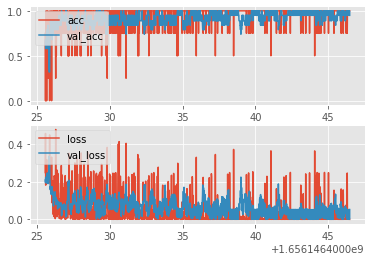

In [11]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

model_name = MODEL_NAME


def create_acc_loss_graph(model_name):
    contents = open("model.log", "r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss, epoch = c.split(",")

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))


    fig = plt.figure()

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)


    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(times,losses, label="loss")
    ax2.plot(times,val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

create_acc_loss_graph(model_name)

In [12]:
val_acc, val_loss = test(size=19)
print(val_acc, val_loss)

0.9473684210526315 tensor(0.0521, device='cuda:0')
